In [1]:
import tensorflow as tf

print(tf.__version__)

from tensorflow.keras.models                import Sequential, Model
from tensorflow.keras.layers                import *
from tensorflow.keras.preprocessing.image   import ImageDataGenerator
from tensorflow.keras.utils                 import to_categorical
from tensorflow.keras.optimizers            import SGD, RMSprop, Adam, Adagrad, Adadelta

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import class_weight

import matplotlib.pyplot as plt
import random
# import cv2
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec
import seaborn as sns
import sklearn
import scipy
import skimage
from skimage.transform import resize
from tqdm import tqdm
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve,KFold,cross_val_score,StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

2023-09-10 23:40:13.583755: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-10 23:40:13.772545: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-10 23:40:16.959123: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-09-10 23:40:16.959278: W tensorflow/strea

2.10.1


In [2]:
# !git clone https://github.com/ardamavi/Sign-Language-Digits-Dataset.git

In [3]:
# !pip install split-folders 

In [4]:
# import splitfolders
# import os

In [5]:
# path = "Sign-Language-Digits-Dataset/Dataset"

# splitfolders.ratio(path, seed=777, output="Train-Validation-Test-Dataset", ratio=(0.7, 0.15, 0.15))

In [6]:
train_path = "Train-Validation-Test-Dataset/train"
val_path = "Train-Validation-Test-Dataset/val"
test_path = "Train-Validation-Test-Dataset/test"

In [7]:
from tensorflow.keras.preprocessing.image   import ImageDataGenerator

##Clasificamos las imagenes
bs = 32 #bach size
k = 2
# Generador de imágenes de entrenamiento.
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=(0.3),
        zoom_range=(0.3),
        width_shift_range=(0.2),
        height_shift_range=(0.2),
        # validation_split = 0.2,
        brightness_range=(0.05,0.85),
        horizontal_flip=False)

# Carga de imágenes al generador de entrenamiento desde directorio.
train_generator = train_datagen.flow_from_directory(
        train_path,
        class_mode='categorical',
        shuffle=True,
        target_size=(28*k, 28*k),
        color_mode = 'rgb', 
        # subset = 'training',
        batch_size=bs)

valid_generator = train_datagen.flow_from_directory(
        val_path,
        class_mode='categorical',
        shuffle=False,
        target_size=(28*k, 28*k),
        color_mode = 'rgb', 
        # subset = 'validation',
        batch_size=bs)

test_generator = train_datagen.flow_from_directory(
        test_path,
        class_mode='categorical',
        shuffle=False,
        target_size=(28*k, 28*k),
        color_mode = 'rgb', 
        # subset = 'validation',
        batch_size=bs)

Found 1438 images belonging to 10 classes.
Found 304 images belonging to 10 classes.
Found 320 images belonging to 10 classes.


In [8]:
from numpy.random import seed
tf.keras.utils.set_random_seed(42)# keras seed fixing
tf.random.set_seed(42)# tensorflow seed fixing

#Visualizamos la estructura del modelo que vamos a utilizar
model = tf.keras.applications.VGG19()
model.summary()
print(len(model.layers))

2023-09-10 23:40:21.911908: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-09-10 23:40:21.911966: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-09-10 23:40:21.912001: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9c1252eef9de): /proc/driver/nvidia/version does not exist
2023-09-10 23:40:21.912251: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in 

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [9]:
##DEFINIMOS EL MODELO
num_classes = 10
epochs = 50

# VGG19
# Importamos el modelo que queremos utilizar con los argumentos que queremos
VGG19_model = tf.keras.applications.VGG19(input_shape=(28*k,28*k,3),
                                          include_top=False,
                                          weights='imagenet')

print(len(VGG19_model.layers))
#Congelamos  las 6 primeras caps del modelo para proceder a entrenar las demás
for layer in VGG19_model.layers[:6]:
  layer.trainable = False

# Creamos un nuevo modelo vacio.
model = tf.keras.Sequential()

# Añadimos el modelo preentrenado como si se tratase de una capa.
model.add(VGG19_model)

# Continuamos añadiendo más capas que sí serán entrenadas...
from tensorflow.keras import regularizers
model.add(Flatten())
model.add(Dense(512, kernel_regularizer=regularizers.l2(0.01), activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(64, kernel_regularizer=regularizers.l2(0.01), activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation = 'softmax'))

22


In [10]:
from numpy.random import seed
tf.keras.utils.set_random_seed(42)# keras seed fixing
tf.random.set_seed(42)# tensorflow seed fixing

## EJECUCION DEL MODELO
model.compile(loss="categorical_crossentropy", 
              optimizer= SGD(learning_rate=0.001),
              metrics=['accuracy'])

#Agregamos un callback
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

checkpointer = ModelCheckpoint(filepath='model-05', verbose=1, save_best_only=True,
                               monitor = 'accuracy', mode = 'max')
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=3, min_lr=0.000001)

history= model.fit(train_generator, callbacks = [reduce_lr, checkpointer], epochs=epochs)

Epoch 1/50
45/45 [==============================] - ETA: 0s - loss: 8.6436 - accuracy: 0.1036
Epoch 1: accuracy improved from -inf to 0.10362, saving model to model-05


INFO:tensorflow:Assets written to: model-05/assets


INFO:tensorflow:Assets written to: model-05/assets


45/45 [==============================] - 105s 2s/step - loss: 8.6436 - accuracy: 0.1036 - lr: 0.0010
Epoch 2/50
45/45 [==============================] - ETA: 0s - loss: 8.5634 - accuracy: 0.1140
Epoch 2: accuracy improved from 0.10362 to 0.11405, saving model to model-05


INFO:tensorflow:Assets written to: model-05/assets


INFO:tensorflow:Assets written to: model-05/assets


45/45 [==============================] - 99s 2s/step - loss: 8.5634 - accuracy: 0.1140 - lr: 0.0010
Epoch 3/50
45/45 [==============================] - ETA: 0s - loss: 8.5153 - accuracy: 0.1558
Epoch 3: accuracy improved from 0.11405 to 0.15577, saving model to model-05


INFO:tensorflow:Assets written to: model-05/assets


INFO:tensorflow:Assets written to: model-05/assets


45/45 [==============================] - 109s 2s/step - loss: 8.5153 - accuracy: 0.1558 - lr: 0.0010
Epoch 4/50
45/45 [==============================] - ETA: 0s - loss: 8.4609 - accuracy: 0.1794
Epoch 4: accuracy improved from 0.15577 to 0.17942, saving model to model-05


INFO:tensorflow:Assets written to: model-05/assets


INFO:tensorflow:Assets written to: model-05/assets


45/45 [==============================] - 105s 2s/step - loss: 8.4609 - accuracy: 0.1794 - lr: 0.0010
Epoch 5/50
45/45 [==============================] - ETA: 0s - loss: 8.3698 - accuracy: 0.2337
Epoch 5: accuracy improved from 0.17942 to 0.23366, saving model to model-05


INFO:tensorflow:Assets written to: model-05/assets


INFO:tensorflow:Assets written to: model-05/assets


45/45 [==============================] - 104s 2s/step - loss: 8.3698 - accuracy: 0.2337 - lr: 0.0010
Epoch 6/50
45/45 [==============================] - ETA: 0s - loss: 8.2028 - accuracy: 0.2900
Epoch 6: accuracy improved from 0.23366 to 0.28999, saving model to model-05


INFO:tensorflow:Assets written to: model-05/assets


INFO:tensorflow:Assets written to: model-05/assets


45/45 [==============================] - 104s 2s/step - loss: 8.2028 - accuracy: 0.2900 - lr: 0.0010
Epoch 7/50
45/45 [==============================] - ETA: 0s - loss: 8.0412 - accuracy: 0.3380
Epoch 7: accuracy improved from 0.28999 to 0.33797, saving model to model-05


INFO:tensorflow:Assets written to: model-05/assets


INFO:tensorflow:Assets written to: model-05/assets


45/45 [==============================] - 106s 2s/step - loss: 8.0412 - accuracy: 0.3380 - lr: 0.0010
Epoch 8/50
45/45 [==============================] - ETA: 0s - loss: 7.9196 - accuracy: 0.3679
Epoch 8: accuracy improved from 0.33797 to 0.36787, saving model to model-05


INFO:tensorflow:Assets written to: model-05/assets


INFO:tensorflow:Assets written to: model-05/assets


45/45 [==============================] - 105s 2s/step - loss: 7.9196 - accuracy: 0.3679 - lr: 0.0010
Epoch 9/50
45/45 [==============================] - ETA: 0s - loss: 7.7630 - accuracy: 0.4374
Epoch 9: accuracy improved from 0.36787 to 0.43741, saving model to model-05


INFO:tensorflow:Assets written to: model-05/assets


INFO:tensorflow:Assets written to: model-05/assets


45/45 [==============================] - 104s 2s/step - loss: 7.7630 - accuracy: 0.4374 - lr: 0.0010
Epoch 10/50
45/45 [==============================] - ETA: 0s - loss: 7.6233 - accuracy: 0.4910
Epoch 10: accuracy improved from 0.43741 to 0.49096, saving model to model-05


INFO:tensorflow:Assets written to: model-05/assets


INFO:tensorflow:Assets written to: model-05/assets


45/45 [==============================] - 104s 2s/step - loss: 7.6233 - accuracy: 0.4910 - lr: 0.0010
Epoch 11/50
45/45 [==============================] - ETA: 0s - loss: 7.4588 - accuracy: 0.5299
Epoch 11: accuracy improved from 0.49096 to 0.52990, saving model to model-05


INFO:tensorflow:Assets written to: model-05/assets


INFO:tensorflow:Assets written to: model-05/assets


45/45 [==============================] - 105s 2s/step - loss: 7.4588 - accuracy: 0.5299 - lr: 0.0010
Epoch 12/50
45/45 [==============================] - ETA: 0s - loss: 7.2587 - accuracy: 0.5974
Epoch 12: accuracy improved from 0.52990 to 0.59736, saving model to model-05


INFO:tensorflow:Assets written to: model-05/assets


INFO:tensorflow:Assets written to: model-05/assets


45/45 [==============================] - 104s 2s/step - loss: 7.2587 - accuracy: 0.5974 - lr: 0.0010
Epoch 13/50
45/45 [==============================] - ETA: 0s - loss: 7.2136 - accuracy: 0.6266
Epoch 13: accuracy improved from 0.59736 to 0.62656, saving model to model-05


INFO:tensorflow:Assets written to: model-05/assets


INFO:tensorflow:Assets written to: model-05/assets


45/45 [==============================] - 101s 2s/step - loss: 7.2136 - accuracy: 0.6266 - lr: 0.0010
Epoch 14/50
45/45 [==============================] - ETA: 0s - loss: 7.0278 - accuracy: 0.6843
Epoch 14: accuracy improved from 0.62656 to 0.68428, saving model to model-05


INFO:tensorflow:Assets written to: model-05/assets


INFO:tensorflow:Assets written to: model-05/assets


45/45 [==============================] - 103s 2s/step - loss: 7.0278 - accuracy: 0.6843 - lr: 0.0010
Epoch 15/50
45/45 [==============================] - ETA: 0s - loss: 6.9700 - accuracy: 0.7135
Epoch 15: accuracy improved from 0.68428 to 0.71349, saving model to model-05


INFO:tensorflow:Assets written to: model-05/assets


INFO:tensorflow:Assets written to: model-05/assets


45/45 [==============================] - 104s 2s/step - loss: 6.9700 - accuracy: 0.7135 - lr: 0.0010
Epoch 16/50
45/45 [==============================] - ETA: 0s - loss: 6.9039 - accuracy: 0.7114
Epoch 16: accuracy did not improve from 0.71349
45/45 [==============================] - 99s 2s/step - loss: 6.9039 - accuracy: 0.7114 - lr: 0.0010
Epoch 17/50
45/45 [==============================] - ETA: 0s - loss: 6.8241 - accuracy: 0.7524
Epoch 17: accuracy improved from 0.71349 to 0.75243, saving model to model-05


INFO:tensorflow:Assets written to: model-05/assets


INFO:tensorflow:Assets written to: model-05/assets


45/45 [==============================] - 103s 2s/step - loss: 6.8241 - accuracy: 0.7524 - lr: 0.0010
Epoch 18/50
45/45 [==============================] - ETA: 0s - loss: 6.6762 - accuracy: 0.8025
Epoch 18: accuracy improved from 0.75243 to 0.80250, saving model to model-05


INFO:tensorflow:Assets written to: model-05/assets


INFO:tensorflow:Assets written to: model-05/assets


45/45 [==============================] - 104s 2s/step - loss: 6.6762 - accuracy: 0.8025 - lr: 0.0010
Epoch 19/50
45/45 [==============================] - ETA: 0s - loss: 6.6351 - accuracy: 0.8025
Epoch 19: accuracy did not improve from 0.80250
45/45 [==============================] - 101s 2s/step - loss: 6.6351 - accuracy: 0.8025 - lr: 0.0010
Epoch 20/50
45/45 [==============================] - ETA: 0s - loss: 6.6128 - accuracy: 0.8136
Epoch 20: accuracy improved from 0.80250 to 0.81363, saving model to model-05


INFO:tensorflow:Assets written to: model-05/assets


INFO:tensorflow:Assets written to: model-05/assets


45/45 [==============================] - 102s 2s/step - loss: 6.6128 - accuracy: 0.8136 - lr: 0.0010
Epoch 21/50
45/45 [==============================] - ETA: 0s - loss: 6.5190 - accuracy: 0.8484
Epoch 21: accuracy improved from 0.81363 to 0.84840, saving model to model-05


INFO:tensorflow:Assets written to: model-05/assets


INFO:tensorflow:Assets written to: model-05/assets


45/45 [==============================] - 102s 2s/step - loss: 6.5190 - accuracy: 0.8484 - lr: 0.0010
Epoch 22/50
45/45 [==============================] - ETA: 0s - loss: 6.5299 - accuracy: 0.8387
Epoch 22: accuracy did not improve from 0.84840
45/45 [==============================] - 101s 2s/step - loss: 6.5299 - accuracy: 0.8387 - lr: 0.0010
Epoch 23/50
45/45 [==============================] - ETA: 0s - loss: 6.4923 - accuracy: 0.8463
Epoch 23: accuracy did not improve from 0.84840
45/45 [==============================] - 100s 2s/step - loss: 6.4923 - accuracy: 0.8463 - lr: 0.0010
Epoch 24/50
45/45 [==============================] - ETA: 0s - loss: 6.3957 - accuracy: 0.8776
Epoch 24: accuracy improved from 0.84840 to 0.87761, saving model to model-05


INFO:tensorflow:Assets written to: model-05/assets


INFO:tensorflow:Assets written to: model-05/assets


45/45 [==============================] - 103s 2s/step - loss: 6.3957 - accuracy: 0.8776 - lr: 0.0010
Epoch 25/50
45/45 [==============================] - ETA: 0s - loss: 6.4358 - accuracy: 0.8526
Epoch 25: accuracy did not improve from 0.87761
45/45 [==============================] - 97s 2s/step - loss: 6.4358 - accuracy: 0.8526 - lr: 0.0010
Epoch 26/50
45/45 [==============================] - ETA: 0s - loss: 6.3656 - accuracy: 0.8818
Epoch 26: accuracy improved from 0.87761 to 0.88178, saving model to model-05


INFO:tensorflow:Assets written to: model-05/assets


INFO:tensorflow:Assets written to: model-05/assets


45/45 [==============================] - 101s 2s/step - loss: 6.3656 - accuracy: 0.8818 - lr: 0.0010
Epoch 27/50
45/45 [==============================] - ETA: 0s - loss: 6.3374 - accuracy: 0.8818
Epoch 27: accuracy did not improve from 0.88178
45/45 [==============================] - 97s 2s/step - loss: 6.3374 - accuracy: 0.8818 - lr: 0.0010
Epoch 28/50
45/45 [==============================] - ETA: 0s - loss: 6.2989 - accuracy: 0.8992
Epoch 28: accuracy improved from 0.88178 to 0.89917, saving model to model-05


INFO:tensorflow:Assets written to: model-05/assets


INFO:tensorflow:Assets written to: model-05/assets


45/45 [==============================] - 102s 2s/step - loss: 6.2989 - accuracy: 0.8992 - lr: 0.0010
Epoch 29/50
45/45 [==============================] - ETA: 0s - loss: 6.2931 - accuracy: 0.8922
Epoch 29: accuracy did not improve from 0.89917
45/45 [==============================] - 96s 2s/step - loss: 6.2931 - accuracy: 0.8922 - lr: 0.0010
Epoch 30/50
45/45 [==============================] - ETA: 0s - loss: 6.2456 - accuracy: 0.9110
Epoch 30: accuracy improved from 0.89917 to 0.91099, saving model to model-05


INFO:tensorflow:Assets written to: model-05/assets


INFO:tensorflow:Assets written to: model-05/assets


45/45 [==============================] - 102s 2s/step - loss: 6.2456 - accuracy: 0.9110 - lr: 0.0010
Epoch 31/50
45/45 [==============================] - ETA: 0s - loss: 6.2235 - accuracy: 0.9221
Epoch 31: accuracy improved from 0.91099 to 0.92211, saving model to model-05


INFO:tensorflow:Assets written to: model-05/assets


INFO:tensorflow:Assets written to: model-05/assets


45/45 [==============================] - 102s 2s/step - loss: 6.2235 - accuracy: 0.9221 - lr: 0.0010
Epoch 32/50
45/45 [==============================] - ETA: 0s - loss: 6.2020 - accuracy: 0.9103
Epoch 32: accuracy did not improve from 0.92211
45/45 [==============================] - 97s 2s/step - loss: 6.2020 - accuracy: 0.9103 - lr: 0.0010
Epoch 33/50
45/45 [==============================] - ETA: 0s - loss: 6.1519 - accuracy: 0.9263
Epoch 33: accuracy improved from 0.92211 to 0.92629, saving model to model-05


INFO:tensorflow:Assets written to: model-05/assets


INFO:tensorflow:Assets written to: model-05/assets


45/45 [==============================] - 101s 2s/step - loss: 6.1519 - accuracy: 0.9263 - lr: 0.0010
Epoch 34/50
45/45 [==============================] - ETA: 0s - loss: 6.1475 - accuracy: 0.9312
Epoch 34: accuracy improved from 0.92629 to 0.93115, saving model to model-05


INFO:tensorflow:Assets written to: model-05/assets


INFO:tensorflow:Assets written to: model-05/assets


45/45 [==============================] - 101s 2s/step - loss: 6.1475 - accuracy: 0.9312 - lr: 0.0010
Epoch 35/50
45/45 [==============================] - ETA: 0s - loss: 6.1135 - accuracy: 0.9346
Epoch 35: accuracy improved from 0.93115 to 0.93463, saving model to model-05


INFO:tensorflow:Assets written to: model-05/assets


INFO:tensorflow:Assets written to: model-05/assets


45/45 [==============================] - 102s 2s/step - loss: 6.1135 - accuracy: 0.9346 - lr: 0.0010
Epoch 36/50
45/45 [==============================] - ETA: 0s - loss: 6.0968 - accuracy: 0.9367
Epoch 36: accuracy improved from 0.93463 to 0.93672, saving model to model-05


INFO:tensorflow:Assets written to: model-05/assets


INFO:tensorflow:Assets written to: model-05/assets


45/45 [==============================] - 101s 2s/step - loss: 6.0968 - accuracy: 0.9367 - lr: 0.0010
Epoch 37/50
45/45 [==============================] - ETA: 0s - loss: 6.0979 - accuracy: 0.9318
Epoch 37: accuracy did not improve from 0.93672
45/45 [==============================] - 98s 2s/step - loss: 6.0979 - accuracy: 0.9318 - lr: 0.0010
Epoch 38/50
45/45 [==============================] - ETA: 0s - loss: 6.0829 - accuracy: 0.9277
Epoch 38: accuracy did not improve from 0.93672
45/45 [==============================] - 99s 2s/step - loss: 6.0829 - accuracy: 0.9277 - lr: 0.0010
Epoch 39/50
45/45 [==============================] - ETA: 0s - loss: 6.0740 - accuracy: 0.9263
Epoch 39: accuracy did not improve from 0.93672
45/45 [==============================] - 99s 2s/step - loss: 6.0740 - accuracy: 0.9263 - lr: 0.0010
Epoch 40/50
45/45 [==============================] - ETA: 0s - loss: 6.0362 - accuracy: 0.9423
Epoch 40: accuracy improved from 0.93672 to 0.94228, saving model to model-

INFO:tensorflow:Assets written to: model-05/assets


INFO:tensorflow:Assets written to: model-05/assets


45/45 [==============================] - 108s 2s/step - loss: 6.0362 - accuracy: 0.9423 - lr: 0.0010
Epoch 41/50
45/45 [==============================] - ETA: 0s - loss: 6.0326 - accuracy: 0.9353
Epoch 41: accuracy did not improve from 0.94228
45/45 [==============================] - 98s 2s/step - loss: 6.0326 - accuracy: 0.9353 - lr: 0.0010
Epoch 42/50
45/45 [==============================] - ETA: 0s - loss: 5.9952 - accuracy: 0.9485
Epoch 42: accuracy improved from 0.94228 to 0.94854, saving model to model-05


INFO:tensorflow:Assets written to: model-05/assets


INFO:tensorflow:Assets written to: model-05/assets


45/45 [==============================] - 100s 2s/step - loss: 5.9952 - accuracy: 0.9485 - lr: 0.0010
Epoch 43/50
45/45 [==============================] - ETA: 0s - loss: 5.9852 - accuracy: 0.9458
Epoch 43: accuracy did not improve from 0.94854
45/45 [==============================] - 98s 2s/step - loss: 5.9852 - accuracy: 0.9458 - lr: 0.0010
Epoch 44/50
45/45 [==============================] - ETA: 0s - loss: 5.9494 - accuracy: 0.9555
Epoch 44: accuracy improved from 0.94854 to 0.95549, saving model to model-05


INFO:tensorflow:Assets written to: model-05/assets


INFO:tensorflow:Assets written to: model-05/assets


45/45 [==============================] - 101s 2s/step - loss: 5.9494 - accuracy: 0.9555 - lr: 0.0010
Epoch 45/50
45/45 [==============================] - ETA: 0s - loss: 5.9609 - accuracy: 0.9485
Epoch 45: accuracy did not improve from 0.95549
45/45 [==============================] - 97s 2s/step - loss: 5.9609 - accuracy: 0.9485 - lr: 0.0010
Epoch 46/50
45/45 [==============================] - ETA: 0s - loss: 5.9324 - accuracy: 0.9576
Epoch 46: accuracy improved from 0.95549 to 0.95758, saving model to model-05


INFO:tensorflow:Assets written to: model-05/assets


INFO:tensorflow:Assets written to: model-05/assets


45/45 [==============================] - 105s 2s/step - loss: 5.9324 - accuracy: 0.9576 - lr: 0.0010
Epoch 47/50
45/45 [==============================] - ETA: 0s - loss: 5.9497 - accuracy: 0.9423
Epoch 47: accuracy did not improve from 0.95758
45/45 [==============================] - 98s 2s/step - loss: 5.9497 - accuracy: 0.9423 - lr: 0.0010
Epoch 48/50
45/45 [==============================] - ETA: 0s - loss: 5.9237 - accuracy: 0.9499
Epoch 48: accuracy did not improve from 0.95758
45/45 [==============================] - 97s 2s/step - loss: 5.9237 - accuracy: 0.9499 - lr: 0.0010
Epoch 49/50
45/45 [==============================] - ETA: 0s - loss: 5.9279 - accuracy: 0.9471
Epoch 49: accuracy did not improve from 0.95758
45/45 [==============================] - 98s 2s/step - loss: 5.9279 - accuracy: 0.9471 - lr: 0.0010
Epoch 50/50
45/45 [==============================] - ETA: 0s - loss: 5.9437 - accuracy: 0.9451
Epoch 50: accuracy did not improve from 0.95758
45/45 [====================

In [11]:
preds_test = model.predict(test_generator)

10/10 [==============================] - 7s 713ms/step


In [12]:
evaluate_test = model.evaluate(test_generator)

10/10 [==============================] - 7s 637ms/step - loss: 5.8618 - accuracy: 0.9469


In [13]:
evaluate_test

[5.861830711364746, 0.9468749761581421]

In [14]:
y_preds_test = np.array([np.argmax(x) for x in preds_test])
y_preds_test

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       7, 2, 2, 2, 2, 2, 2, 2, 6, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 8, 7, 8, 8, 8, 9, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 9, 7, 8, 4, 8,
       8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,

In [15]:
y_real_test = test_generator.classes
y_real_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,

In [16]:
accuracy_test = accuracy_score(y_real_test, y_preds_test)
accuracy_test

0.95625

In [17]:
cm_test = confusion_matrix(y_real_test, y_preds_test)
cm_test

array([[31,  1,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 32,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 30,  1,  0,  0,  0,  1,  0,  0],
       [ 0,  0,  0, 30,  0,  1,  1,  0,  0,  0],
       [ 0,  0,  0,  0, 31,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 32,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  0, 31,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  1, 30,  1,  0],
       [ 0,  0,  0,  0,  2,  0,  0,  1, 27,  2],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 32]])

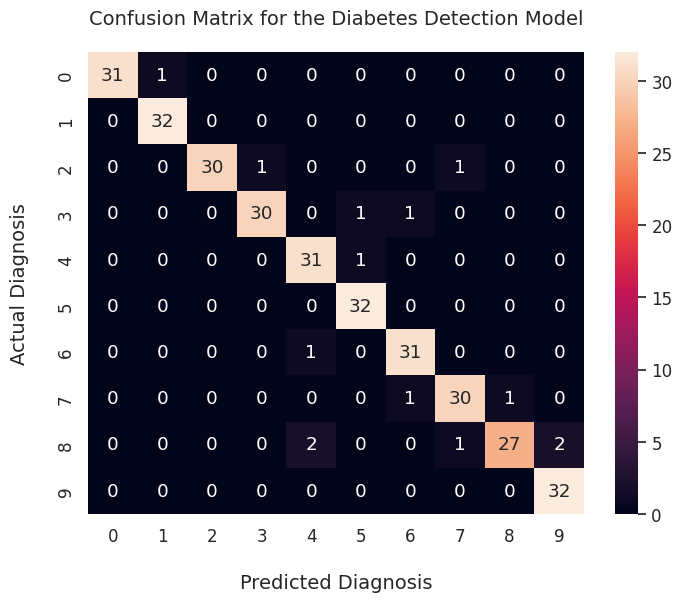

In [18]:
plt.figure(figsize=(8,6), dpi=100)
# Scale up the size of all text
sns.set(font_scale = 1.1)

# Plot Confusion Matrix using Seaborn heatmap()
# Parameters:
# first param - confusion matrix in array format   
# annot = True: show the numbers in each heatmap cell
# fmt = 'd': show numbers as integers. 
ax = sns.heatmap(cm_test, annot=True, fmt='d', )

# set x-axis label and ticks. 
ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
# ax.xaxis.set_ticklabels(['Negative', 'Positive'])

# set y-axis label and ticks
ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
# ax.yaxis.set_ticklabels(['Negative', 'Positive'])

# set plot title
ax.set_title("Confusion Matrix for the Diabetes Detection Model", fontsize=14, pad=20)

plt.show()

In [19]:
preds_val = model.predict(valid_generator)

10/10 [==============================] - 6s 640ms/step


In [20]:
evaluate_val = model.evaluate(valid_generator)

10/10 [==============================] - 6s 560ms/step - loss: 5.8427 - accuracy: 0.9803


In [21]:
evaluate_val

[5.842674732208252, 0.9802631735801697]

In [22]:
y_preds_val = np.array([np.argmax(x) for x in preds_val])
y_preds_val

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 7, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 2, 3, 3, 3, 3, 6, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4,
       4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 9, 9, 9, 9,

In [23]:
y_real_val = valid_generator.classes
y_real_val

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,

In [24]:
accuracy_val = accuracy_score(y_real_val, y_preds_val)
accuracy_val

0.9539473684210527

In [25]:
cm_val = confusion_matrix(y_real_val, y_preds_val)
cm_val

array([[30,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 30,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 28,  1,  0,  0,  0,  1,  0,  0],
       [ 0,  0,  3, 25,  0,  1,  1,  0,  0,  0],
       [ 0,  0,  0,  0, 28,  3,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  1, 30,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  0, 30,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 29,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 31,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  1, 29]])

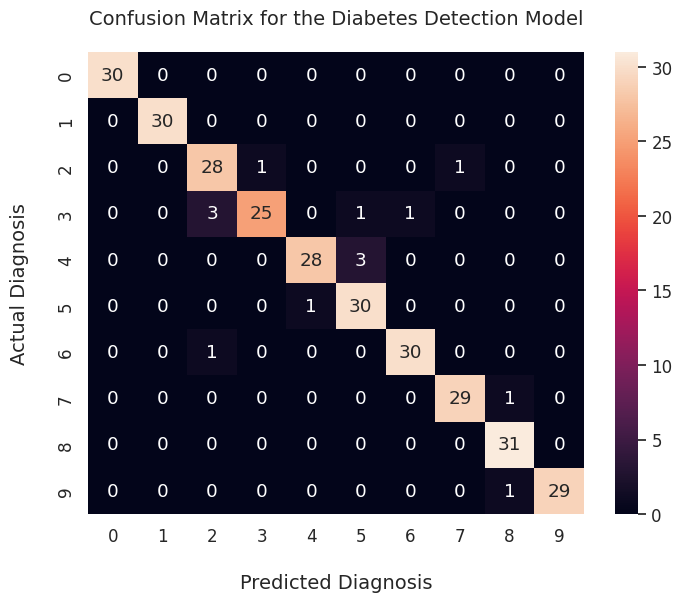

In [26]:
plt.figure(figsize=(8,6), dpi=100)
# Scale up the size of all text
sns.set(font_scale = 1.1)

# Plot Confusion Matrix using Seaborn heatmap()
# Parameters:
# first param - confusion matrix in array format   
# annot = True: show the numbers in each heatmap cell
# fmt = 'd': show numbers as integers. 
ax = sns.heatmap(cm_val, annot=True, fmt='d', )

# set x-axis label and ticks. 
ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
# ax.xaxis.set_ticklabels(['Negative', 'Positive'])

# set y-axis label and ticks
ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
# ax.yaxis.set_ticklabels(['Negative', 'Positive'])

# set plot title
ax.set_title("Confusion Matrix for the Diabetes Detection Model", fontsize=14, pad=20)

plt.show()